d:\Python\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
d:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best Hyperparameters: {'batch_size': 32, 'epochs': 100, 'model__optimizer': 'adam', 'model__units': 50}
R² Score: 0.904
RMSE: 1.634
MAE: 1.249


d:\Python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Admin\AppData\Local\Temp\ipykernel_1628\112113028.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_features.fillna(method='ffill', inplace=True)  # Forward fill missing values


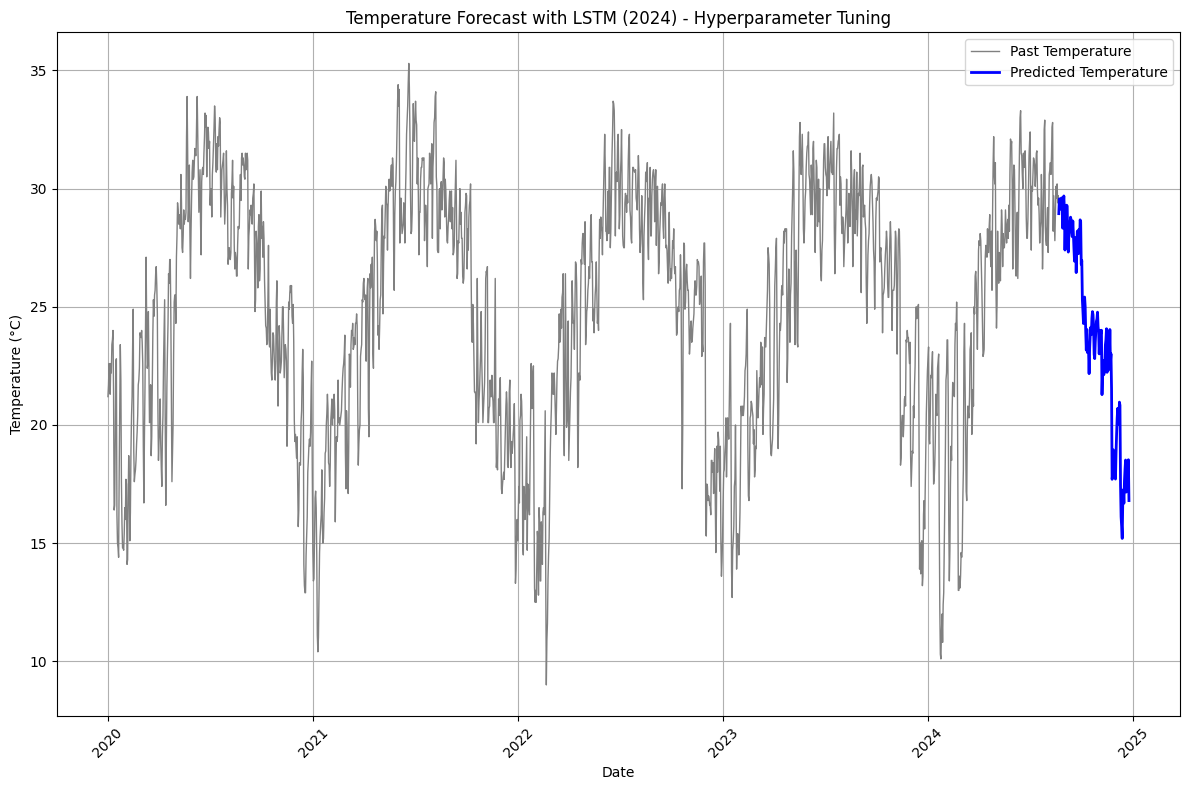

In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from scikeras.wrappers import KerasRegressor

# Step 1: Load the dataset
file_path = '../dataset/Data.csv'  # Path to the dataset
data = pd.read_csv(file_path)  # Read the dataset into a DataFrame

# Step 2: Prepare the data
data['datetime'] = pd.to_datetime(data['datetime'], format='%m/%d/%Y')  # Convert datetime column to datetime objects
data['day_of_year'] = data['datetime'].dt.dayofyear  # Extract the day of the year from the datetime

# Step 3: Extract features and labels
X = data[['feelslike', 'tempmax', 'feelslikemax', 'tempmin', 'feelslikemin', 'dew', 'sealevelpressure', 'humidity']]  # Related Features
y = data['temp']  # Target variable: temperature

# Step 4: Normalize the features and labels
scaler_X = MinMaxScaler()  # Initialize the scaler for features
scaler_y = MinMaxScaler()  # Initialize the scaler for labels
X_scaled = scaler_X.fit_transform(X)  # Scale features
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()  # Scale labels

# Step 5: Create sequences for LSTM
def create_sequences(data, labels, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i+seq_length])  # Append sequence of features
        y_seq.append(labels[i+seq_length])  # Append corresponding label
    return np.array(X_seq), np.array(y_seq)

seq_length = 7  # Length of sequences for LSTM
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length)  # Create sequences

# Step 6: Train-test split
split_index = int(len(X_seq) * 0.8)
X_train = X_seq[:split_index]
X_test = X_seq[split_index:]
y_train = y_seq[:split_index]
y_test = y_seq[split_index:]

# Step 7: Build the LSTM model function
def build_model(units=50, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units, activation='relu', input_shape=(seq_length, X_seq.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Step 8: Wrap the model using KerasRegressor
model = KerasRegressor(model=build_model, verbose=0)

# Step 9: Define the hyperparameters grid
param_grid = {
    'model__units': [50, 100, 150],  # Adjusted to use 'model__' prefix
    'model__optimizer': ['adam', 'RMSprop'],  # Adjusted to use 'model__' prefix
    'batch_size': [16, 32],
    'epochs': [50, 100]
}

# Step 10: Perform Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

# Step 11: Evaluate the model
best_model = grid_result.best_estimator_
y_pred_scaled = best_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print(f"Best Hyperparameters: {grid_result.best_params_}")
print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

# Step 12: Generate future dates
future_dates = pd.date_range(start='2024-08-21', end='2024-12-31')  # Define the range for future dates
future_day_of_year = future_dates.dayofyear  # Extract the day of year for future dates

# Step 13: Create future features using historical averages
historical_averages = data.groupby('day_of_year')[['dew', 'tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'feelslike', 'sealevelpressure', 'humidity']].mean()  # Calculate historical averages

# Step 14: Create a DataFrame with future dates
future_features = pd.DataFrame({
    'day_of_year': future_day_of_year  # Add day of year for future dates
})

# Add historical averages to future features
for col in ['dew', 'tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'feelslike', 'sealevelpressure', 'humidity']:
    future_features[col] = future_features['day_of_year'].map(historical_averages[col])  # Map historical averages to future features

# Ensure future_features has the same columns in the same order as when fitting the scaler
future_features = future_features[['dew', 'tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'feelslike', 'sealevelpressure', 'humidity', 'day_of_year']]

# Handle any missing values by filling with the forward fill method
future_features.fillna(method='ffill', inplace=True)  # Forward fill missing values

# Normalize future features
# Ensure future_features has the same columns in the same order as when fitting the scaler
# Exclude 'day_of_year' before scaling
future_features_for_scaling = future_features.drop(columns=['day_of_year'])
future_features_for_scaling = future_features_for_scaling[scaler_X.feature_names_in_]

# Normalize future features
future_features_scaled = scaler_X.transform(future_features_for_scaling)  # Scale future features

# Step 15: Create sequences for future prediction
future_sequences, _ = create_sequences(future_features_scaled, np.zeros(len(future_features_scaled)), seq_length)  # Create sequences for future predictions

# Ensure future_sequences length is compatible with predictions
num_future_sequences = len(future_sequences)
if num_future_sequences < len(future_dates) - seq_length:
    future_dates = future_dates[-num_future_sequences:]  # Adjust future_dates if necessary

# Step 16: Predict future temperatures
future_predictions_scaled = best_model.predict(future_sequences)  # Predict future temperatures using the best model
future_predictions = scaler_y.inverse_transform(future_predictions_scaled.reshape(-1, 1))  # Inverse transform predictions

# Step 17: Save predictions
future_data = pd.DataFrame({
    'Date': future_dates[:len(future_predictions)],  # Dates for predictions
    'Predicted Temperature': future_predictions.flatten()  # Forecasted temperatures
})
future_data.to_csv('future_weather_predictions_lstm_finetuning.csv', index=False)  # Save predictions to a CSV file

# Step 18: Plot the forecasted temperature and historical data
plt.figure(figsize=(12, 8))
plt.plot(data['datetime'], data['temp'], color='grey', label='Past Temperature', linewidth=1)  # Plot historical temperature data as a grey line
plt.plot(future_data['Date'], future_data['Predicted Temperature'], color='blue', label='Predicted Temperature', linewidth=2)  # Plot forecasted temperature as a blue line
plt.title("Temperature Forecast with LSTM (2024) - Hyperparameter Tuning")  # Title of the plot
plt.xlabel("Date")  # X-axis label
plt.ylabel("Temperature (°C)")  # Y-axis label
plt.legend()  # Show legend
plt.grid(True)  # Show grid
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout
plt.show()  # Display the plot
